# Plot light curves

**Abstract:** Here we check the performance of models by investigating their behaviour on generating a LC from the grid.

In [1]:
%load_ext autoreload 
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect 
import time
import copy
import arviz

import nmma as nmma
from nmma.em.training import SVDTrainingModel
from nmma.em.io import read_photometry_files
from nmma.em.utils import interpolate_nans
from nmma.em.model import SVDLightCurveModel
import nmma.em.model_parameters as model_parameters

params = {"axes.grid": True,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16}

plt.rcParams.update(params)

MODEL_FUNCTIONS = {
    k: v for k, v in model_parameters.__dict__.items() if inspect.isfunction(v)
}

# Choose model and set location of the kilonova lightcurves
base_dir = "/home/urash/twouters/KN_lightcurves/lightcurves/bulla_"
bulla_2019_dir = f"{base_dir}2019"
bulla_2022_dir = f"{base_dir}2022"
bulla_2023_dir = f"{base_dir}2023"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Install wrapt_timeout_decorator if you want timeout simulations.


## Choose the model and its SVD path here:

In [2]:
model_name = "Bu2023Ye"
model_function = MODEL_FUNCTIONS[model_name]
# svd_path = "/home/enlil/ppang/Projects/AT2017gfo_chemical_tf/inference/tensorflow_model"
svd_path = "/home/urash/twouters/nmma_models"

# Select the correct LC dir based on the chosen model
if model_name == "Bu2022Ye":
    lcs_dir = bulla_2022_dir
    
elif model_name == "Bu2019lm":
    lcs_dir = bulla_2019_dir

elif model_name == "Bu2023Ye":
    lcs_dir = bulla_2023_dir

## Preprocessing data

In [3]:
start = time.time()

# Process the KN lightcurves
filenames = os.listdir(lcs_dir)
full_filenames = [os.path.join(lcs_dir, f) for f in filenames]
print(f"There are {len(full_filenames)} lightcurves for this model.")

print("Reading lightcurves and interpolating NaNs...")
data = read_photometry_files(full_filenames)
data = interpolate_nans(data)
keys = list(data.keys())
filts = sorted(list(set(data[keys[0]].keys()) - {"t"}))

print("Reading lightcurves and interpolating NaNs... DONE")

# Get the time array
dat = pd.read_csv(full_filenames[0], delimiter=" ", escapechar='#')
dat = dat.rename(columns={" t[days]": "t"})
t = dat["t"].values

print("Genrating training data...")
training_data, parameters = model_function(data)
print("Genrating training data... DONE")

end = time.time()
print(f"Time taken to read and process lightcurves: {end - start:.2f} seconds")

There are 33792 lightcurves for this model.
Reading lightcurves and interpolating NaNs...
Reading lightcurves and interpolating NaNs... DONE
Genrating training data...
Genrating training data... DONE
Time taken to read and process lightcurves: 121.25 seconds


## Get the models

In [4]:
print("Loading new LC model...")
new_lc_model = SVDLightCurveModel(
        model_name,
        t,
        svd_path=svd_path,
        parameter_conversion=None,
        mag_ncoeff=10,
        lbol_ncoeff=None,
        interpolation_type="tensorflow",
        model_parameters=None,
        local_only=True
)
print("Loading new LC model... DONE")

Loading new LC model...


2024-03-05 16:59:58.671227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 16:59:58.911841: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 16:59:59.988751: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: ~/MultiNest/lib/
2024-03-05 16:59:59.988874: W tensorflow/compiler/xla/stream_executor/

Loaded filter 2massh


2024-03-05 17:00:01.179419: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 17:00:02.390473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22765 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:73:00.0, compute capability: 7.5


Loaded filter 2massj
Loaded filter 2massks
Loaded filter ps1__g
Loaded filter ps1__i
Loaded filter ps1__r
Loaded filter ps1__y
Loaded filter ps1__z
Loaded filter sdssu
Loading new LC model... DONE


## Get the input and output pairs of lightcurve grid

In [5]:
def get_input_values(training_data: dict, parameters: list) -> np.ndarray:
    """
    From a dictionary of training data, extract the input values for the model.
    """
    
    input_values = []
    
    for key in training_data.keys():
        data = training_data[key]
        input_values.append([data[param] for param in parameters])
    
    return np.array(input_values)

In [6]:
def get_output_values(training_data: dict) -> np.ndarray:
    """
    From a dictionary of training data, extract the output values for the model.
    """
    keys = list(training_data.keys())
    if "data" in training_data[keys[0]].keys():
        # This is the version that was in use for NMMA-GPU
        output_values = [training_data[key]["data"] for key in training_data.keys()]
    else:
        # This is the version for NMMA CPU, 12/12/2023
        output_values = []
        for key in training_data.keys():
            data = training_data[key]
            new_list = [data[f] for f in filts]
            output_values.append(new_list)
    
    return np.array(output_values)

In [7]:
# Sanity check:
keys = list(training_data.keys())
example = training_data[keys[0]]
print(example.keys())

dict_keys(['log10_mej_dyn', 'vej_dyn', 'Yedyn', 'log10_mej_wind', 'vej_wind', 'Yewind', 'KNtheta', 't', 'sdssu', 'ps1__g', 'ps1__r', 'ps1__i', 'ps1__z', 'ps1__y', '2massj', '2massh', '2massks'])


In [8]:
input_values = get_input_values(training_data, parameters)
output_values = get_output_values(training_data)

In [9]:
print(np.shape(input_values))
print(np.shape(output_values))

(33792, 7)
(33792, 9, 100)


In [10]:
N = 200
# Select a random subset of indices for the input values
idx_list = np.random.choice(len(input_values), N, replace=False)
sampled_input_values = np.array(input_values[idx_list])
sampled_output_values = np.array(output_values[idx_list])

In [11]:
# For this list, we compute the LCs using the flax model
start = time.time()

new_lc_model_output = []

for i in range(len(sampled_input_values)):
    # Compute the lightcurve
    _, _, mag = nmma.em.utils.calc_lc(t,
                                sampled_input_values[i], 
                                svd_mag_model = new_lc_model.svd_mag_model, 
                                interpolation_type="tensorflow", 
                                filters = filts, 
                                mag_ncoeff = 10
                                )
    # Convert this dictionary to values of the LCs
    mag = mag.values()
    mag = np.array(list(mag))
    new_lc_model_output.append(mag)
end = time.time()
print(f"Computing all the lightcurves for a subset of {N} lightcurves took {end-start} s.")

# Convert to np arrays
new_lc_model_output = np.array(new_lc_model_output)

Computing all the lightcurves for a subset of 200 lightcurves took 8.269874334335327 s.


## Compare MSE or MAE values

TODO: Best to compare this as a distribution, and perhaps best to consider MAE, or some self-defined loss function or error function?

In [12]:
def mse(y_true, y_pred, axis=None):
    return np.mean((y_true - y_pred)**2, axis=axis)

def se(y_true, y_pred):
    return (y_true - y_pred)**2

def mae(y_true, y_pred, axis=None):
    return np.mean(np.abs(y_true - y_pred), axis=axis)

def ae(y_true, y_pred):
    return np.abs(y_true - y_pred)

def my_format(low: float, med: float, high: float, nb: int = 3) -> str:
    med = np.round(med, nb)
    low = med - low
    low = np.round(low, nb)
    high = high - med
    high = np.round(high, nb)
    
    return f"{med} - {low} + {high}"

# # TODO with arviz summarize the errors
# def summarize_data(values: np.array, percentile: float = 0.95) -> None:
    
#     med = np.median(values)
#     result = arviz.hdi(values, hdi_prob = percentile)
    
#     print(my_format(low, med, high))
    
#     return

In [13]:
# # which_dataset = flax_output
# # which_error = mae
# nb_round = 5
# time_left = 0.0
# time_right = 999.0
# mask = (t >= time_left) & (t <= time_right)
# masked_t = t[mask]

# for error_fn, name in zip([mse, mae], ["MSE", "MAE"]):
#     for dataset, dataset_name in zip([new_lc_model_output], ["new"]):
#         # diffs = se(dataset, sampled_output_values)
#         print(f"Computing {name} for {dataset_name} model...")
#         axis = 0
#         a = copy.deepcopy(np.array(dataset)[:, :, mask])
#         b = copy.deepcopy(np.array(sampled_output_values)[:, :, mask])
#         mse_values = error_fn(a, b, axis=axis)
#         mean_mse_values = np.mean(mse_values, axis=axis)
#         for f, val in zip(filts, mean_mse_values):
#             print(f"{f}: {np.round(val, nb_round)}")
            
#         print("Median")
#         mse_values = error_fn(a, b, axis=axis)
#         median_mse_values = np.median(mse_values, axis=axis)
#         for f, val in zip(filts, median_mse_values):
#             print(f"{f}: {np.round(val, nb_round)}")

## Plot lightcurves

['log10_mej_dyn',
 'vej_dyn',
 'Yedyn',
 'log10_mej_wind',
 'vej_wind',
 'Yewind',
 'KNtheta']

(33792, 9, 100)
Lightcurve data
MDyn0.001_vDyn0.25_YeDyn0.15_MWind0.050_vWind0.10_YeWind0.2_theta90.00_dMpc0.dat
log10_mej_dyn: -3.0
vej_dyn: 0.25
Yedyn: 0.15
log10_mej_wind: -1.3010299956639813
vej_wind: 0.1
Yewind: 0.2
KNtheta: 90.0


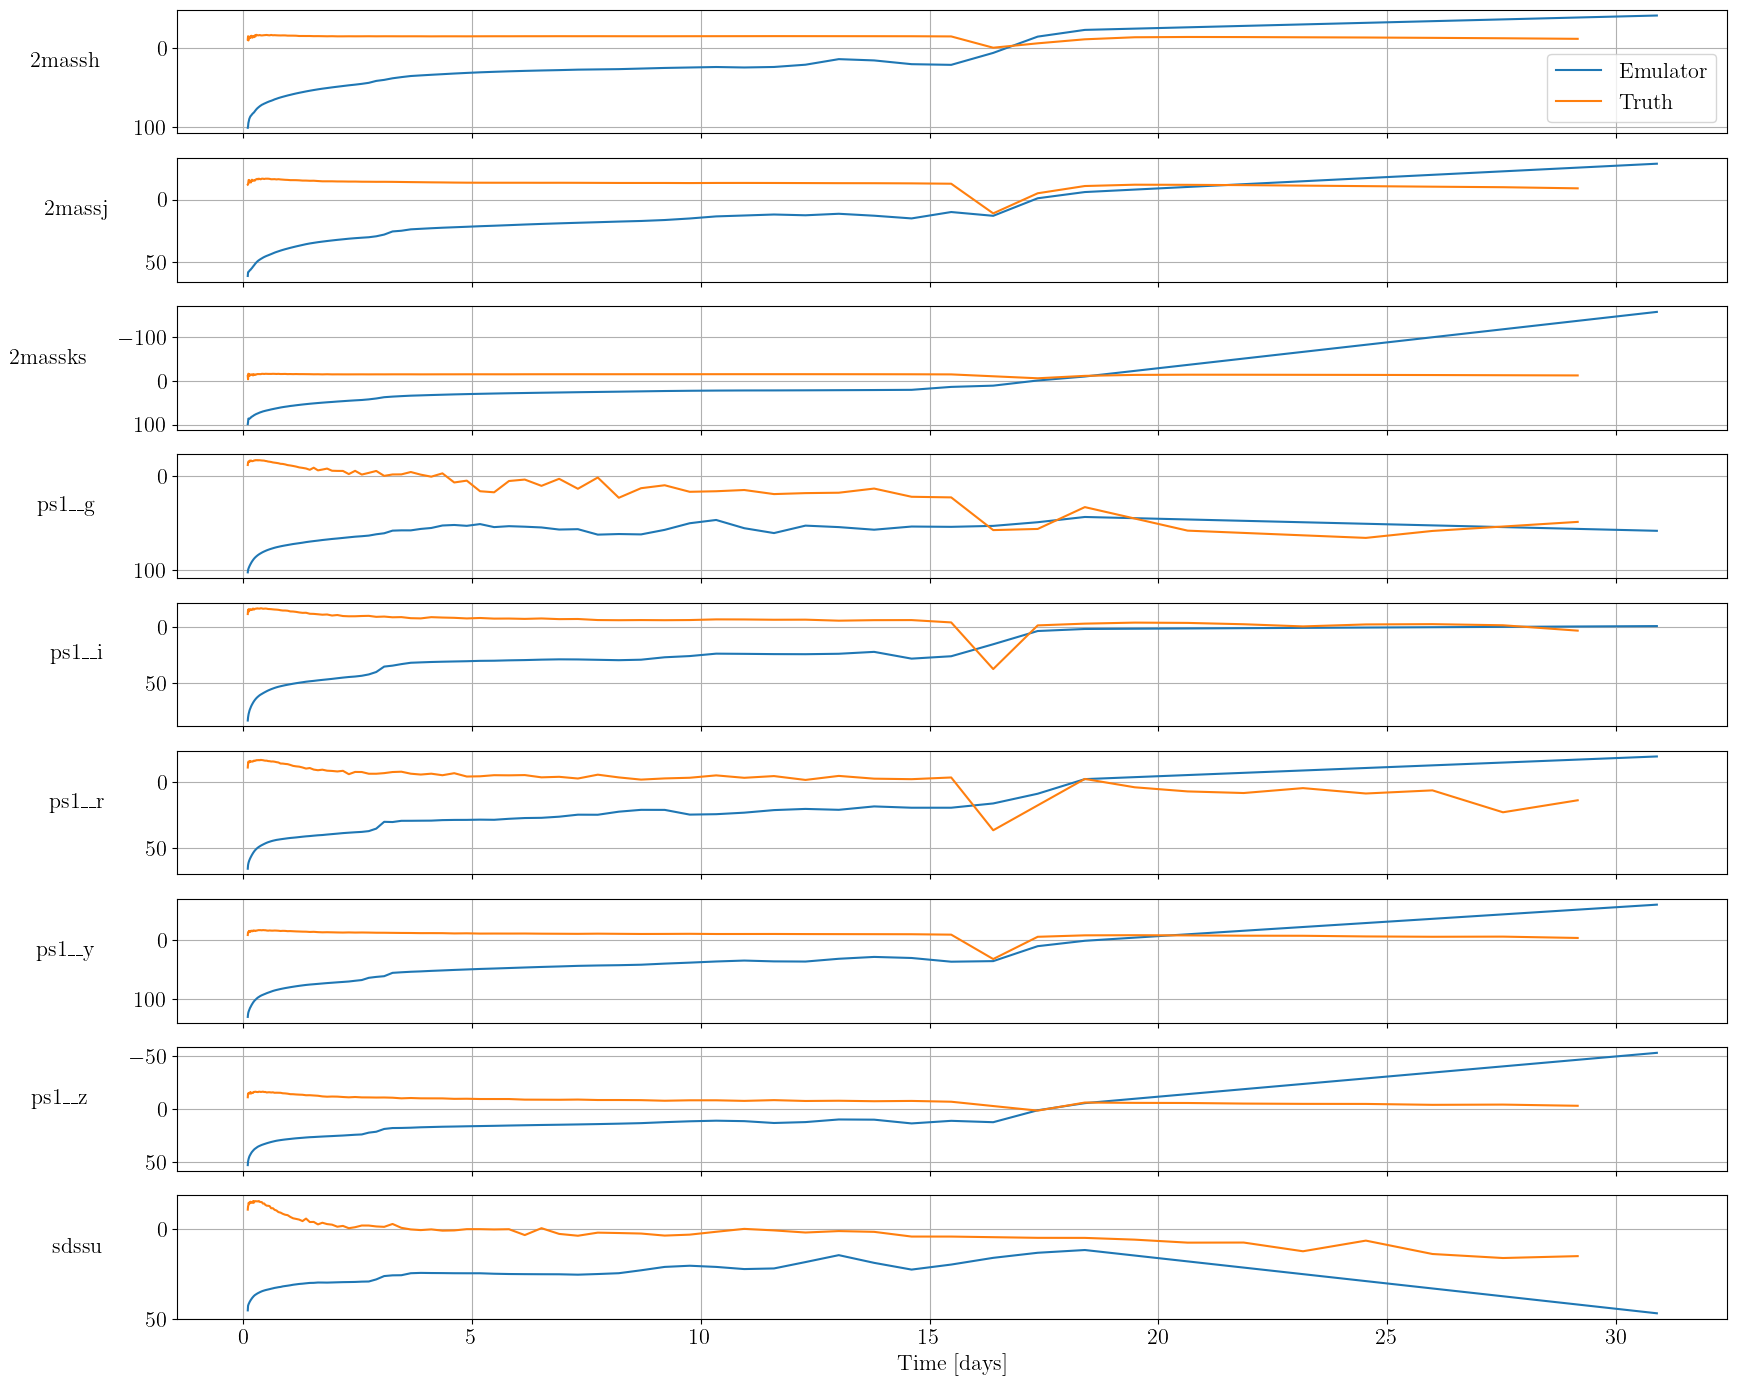

In [19]:
index = 28617
# index = 0

example_key = list(training_data.keys())[index]
example = training_data[example_key]
parameter_values = [example[p] for p in parameters]
output = get_output_values(training_data)
print(np.shape(output))
truth = output[index]

print("Lightcurve data")
print(filenames[index])
for name, value in zip(parameters, parameter_values):
    print(f"{name}: {value}")

_, _, mag = nmma.em.utils.calc_lc(t,
                            parameter_values, 
                            svd_mag_model = new_lc_model.svd_mag_model, 
                            interpolation_type="tensorflow", 
                            filters = filts, 
                            mag_ncoeff = 10
                            )

# Compute the lightcurve
nrow = len(filts)
fig, axs = plt.subplots(nrow, 1, figsize=(20, 17), sharex = True)
t = dat["t"].values

for i, key in enumerate(filts):
    plt.subplot(nrow, 1, i+1)
    plt.plot(t, mag[key], label="Emulator")
    plt.plot(t, truth[i], label="Truth")
    plt.ylabel(key, rotation=0, labelpad=50)
    axs[i].invert_yaxis()
    # plt.grid()
    if i == 0:
        plt.legend()
plt.xlabel("Time [days]")
plt.show()